# [Dacon School] 2주차 숙제
#### 1. 1, 2주차의 내용을 통해 모델이 실거래가를 더 예측 잘 할 수 있도록 "변수 추가" 및 "모델의 파라미터 튜닝"을 해보세요.(early_stopping_rounds를 설정하여 성능 개선이 없을 때 까지 훈련)
    - 꼭 모델의 성능 개선이 있지 않아도 됩니다. 
    - 공식 document 외에도 lightgbm의 파라미터 설명을 잘 정리해둔 글이 많습니다.  
    
#### "데이터 분리" 부분에서 .astype('category' 와 .astype(np.int64)로 했을 때 성능을 비교 해보기.
#### feature_importance를 확인해보기.
#### LightGBM 외에 수업 때 사용했던 모델 이나 다른 모델을 1개 이상 선언하고 결과 확인하기.


#### [LightGBM Document Parameters](https://lightgbm.readthedocs.io/en/latest/Parameters.html)

In [53]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import random
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor


In [54]:
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')

In [55]:
 for column in ['dong', 'jibun', 'apt']:
     busan_element = train[train['city']=='부산광역시'][column].unique()
     seoul_element = train[train['city']=='서울특별시'][column].unique()
     inter_element = set(busan_element)&set(seoul_element)
   
     for element in tqdm(list(inter_element)):
         train.loc[(train['city']=='부산광역시') & (train[column] == element), column] = '부산_{}'.format(element)
         train.loc[(train['city']=='서울특별시') & (train[column] == element), column] = '서울_{}'.format(element)
        

for column in ['dong', 'jibun', 'apt']:
    busan_element = test[test['city']=='부산광역시'][column].unique()
    seoul_element = test[test['city']=='서울특별시'][column].unique()
    inter_element = set(busan_element)&set(seoul_element)
    
    for element in tqdm(list(inter_element)):
        test.loc[(test['city']=='부산광역시') & (test[column] == element), column] = '부산_{}'.format(element)
        test.loc[(test['city']=='서울특별시') & (test[column] == element), column] = '서울_{}'.format(element)
        

100%|██████████| 68/68 [00:00<00:00, 215.24it/s]


In [5]:
#train.to_csv('전처리완료.csv', header=False, index=False)

In [6]:
#train = pd.read_csv('전처리완료.csv') ## '전처리완료'로 파일 저장

### park와 day_care_center 데이터를 train 데이터에 결합하는 과정.

In [56]:


park=pd.read_csv('park.csv')
day_care_center=pd.read_csv('day_care_center.csv')

park = park.drop(['park_exercise_facility', 'park_entertainment_facility', 'park_benefit_facility', 'park_cultural_facitiy','park_facility_other',
          'park_open_year'], axis=1)
day_care_center = day_care_center.drop(['nursing_room_num', 'playground_num', 'CCTV_num', 'is_commuting_vehicle'], axis=1)
day_care_center['teacher_num']=day_care_center['teacher_num'].fillna(day_care_center['teacher_num'].mean())

park_dong_mean = park.groupby('dong').mean().reset_index()
day_care_gu_mean = day_care_center.groupby('gu').mean().reset_index()

for gu, care_baby, teacher in zip(day_care_gu_mean['gu'].values, day_care_gu_mean['day_care_baby_num'].values, day_care_gu_mean['teacher_num'].values):
    park.loc[(park['gu']==gu), 'day_care_baby_num_mean'] = care_baby
    park.loc[(park['gu']==gu), 'teacher_mean'] = teacher
    
    
park['day_care_baby_num_mean']  = park['day_care_baby_num_mean'].fillna(park['day_care_baby_num_mean'].mean())
park['teacher_mean']  = park['teacher_mean'].fillna(park['teacher_mean'].mean())


park_groupby = park.groupby(by='dong').mean().reset_index().iloc[:]


for dong, park_area, day_care_baby_num_mean, teacher_mean in tqdm(zip(park_groupby['dong'].values, park_groupby['park_area'].values, park_groupby['day_care_baby_num_mean'].values, park_groupby['teacher_mean'].values)):
    train.loc[train['dong']==dong, 'day_care_baby_num_mean'] = day_care_baby_num_mean
    train.loc[train['dong']==dong, 'park_area'] = park_area
    train.loc[train['dong']==dong, 'teacher_num'] = teacher_mean
    
    test.loc[train['dong']==dong, 'day_care_baby_num_mean'] = day_care_baby_num_mean
    test.loc[train['dong']==dong, 'park_area'] = park_area
    test.loc[train['dong']==dong, 'teacher_num'] = teacher_mean
    

237it [02:44,  1.44it/s]


### 범주형 변수를 숫자 형태로 인코딩.

In [57]:
LE = LabelEncoder()

LE.fit(list(train['city'])+list(test['city']))
train['city'] = LE.transform(train['city'])
test['city'] = LE.transform(test['city'])
LE.fit(list(train['dong'])+list(test['dong']))
train['dong'] = LE.transform(train['dong'])
test['dong'] = LE.transform(test['dong'])
LE.fit(list(train['jibun'])+list(test['jibun']))
train['jibun'] = LE.transform(train['jibun'])
test['jibun'] = LE.transform(test['jibun'])
LE.fit(list(train['apt'])+list(test['apt']))
train['apt'] = LE.transform(train['apt'])
test['apt'] = LE.transform(test['apt'])
LE.fit(list(train['addr_kr'])+list(test['addr_kr']))
train['addr_kr'] = LE.transform(train['addr_kr'])
test['addr_kr'] = LE.transform(test['addr_kr'])


train['year_of_completion'] = 2017-train['year_of_completion'].values
test['year_of_completion'] = 2017-test['year_of_completion'].values

train['transaction_year'] = 2017 - np.array([int(str(k)[:4]) for k in train['transaction_year_month'].values])
test['transaction_year'] = 2017 - np.array([int(str(k)[:4]) for k in test['transaction_year_month'].values])
train['transaction_month'] = np.array([int(str(k)[4:]) for k in train['transaction_year_month'].values])
test['transaction_month'] = np.array([int(str(k)[4:]) for k in test['transaction_year_month'].values])


LE.fit(list(train['transaction_year_month'])+list(test['transaction_year_month']))
train['transaction_year_month'] = LE.transform(train['transaction_year_month'])
test['transaction_year_month'] = LE.transform(test['transaction_year_month'])

LE.fit(list(train['transaction_date'])+list(test['transaction_date']))
train['transaction_date'] = LE.transform(train['transaction_date'])
test['transaction_date'] = LE.transform(test['transaction_date'])

### 데이터 분리
- .astype('category' 와 .astype(np.int64)로 했을 때 성능을 비교 해보기.

## 1) astype('category') 사용

In [13]:
# astype 및 데이터 분리
category_columns = ['apartment_id', 'city', 'dong', 'jibun', 'apt', 'addr_kr']
for column in category_columns:
    train[column] = train[column].astype('category')                     # 범주형시 category. (lightgbm 시 사용)
    
drop_column = ['transaction_real_price']

X_data = train.drop(drop_column, axis=1)
y_data = train['transaction_real_price'].values
X_train, X_valid, y_train, y_valid = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

### 모델 선언 및 훈련 (LightGBM)


In [14]:
lgbm_model = LGBMRegressor(
    boosting_type='gbdt',
    num_leaves=31,
    max_depth=-1,
    learning_rate=0.1,
    n_estimators=20000,
    objective='regression',
    subsample=1.0,
    colsample_bytree=1.0,
    reg_alpha=0.0,
    reg_lambda=0.0,
    random_state=42,
    n_jobs=-1,
#         max_bin=2*9
)


In [15]:
lgbm_model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='rmse', verbose=200,
              early_stopping_rounds=200)

Training until validation scores don't improve for 200 rounds
[200]	training's rmse: 4266.67	training's l2: 1.82045e+07	valid_1's rmse: 4578.71	valid_1's l2: 2.09646e+07
[400]	training's rmse: 3739.48	training's l2: 1.39837e+07	valid_1's rmse: 4158.8	valid_1's l2: 1.72956e+07
[600]	training's rmse: 3496.09	training's l2: 1.22226e+07	valid_1's rmse: 4015.89	valid_1's l2: 1.61274e+07
[800]	training's rmse: 3343.64	training's l2: 1.118e+07	valid_1's rmse: 3939.71	valid_1's l2: 1.55213e+07
[1000]	training's rmse: 3229.72	training's l2: 1.04311e+07	valid_1's rmse: 3894.88	valid_1's l2: 1.51701e+07
[1200]	training's rmse: 3147.3	training's l2: 9.90549e+06	valid_1's rmse: 3857.89	valid_1's l2: 1.48833e+07
[1400]	training's rmse: 3077.17	training's l2: 9.46898e+06	valid_1's rmse: 3835.1	valid_1's l2: 1.4708e+07
[1600]	training's rmse: 3021.23	training's l2: 9.12784e+06	valid_1's rmse: 3812.48	valid_1's l2: 1.4535e+07
[1800]	training's rmse: 2972.11	training's l2: 8.83345e+06	valid_1's rmse: 38

LGBMRegressor(n_estimators=20000, objective='regression', random_state=42)

# - 성능
- [6675]	
- training's rmse: 2450.84	
- training's l2: 6.00661e+06	
- valid_1's rmse: 3702.83	
- valid_1's l2: 1.3711e+07

### feature_importance를 확인해보기.

In [16]:
def show_feature_importance(model, data):
    df=pd.DataFrame({'column':list(data.columns),
              'score':list(model.feature_importances_),
             })
    plt.figure(figsize=(20,10))
    sns.barplot(x="score", y="column", data=df)
    plt.yticks(size=20)
    plt.xticks(size=20)
    plt.xlabel('score', size=20)
    plt.ylabel('column', size=20)
    plt.show()

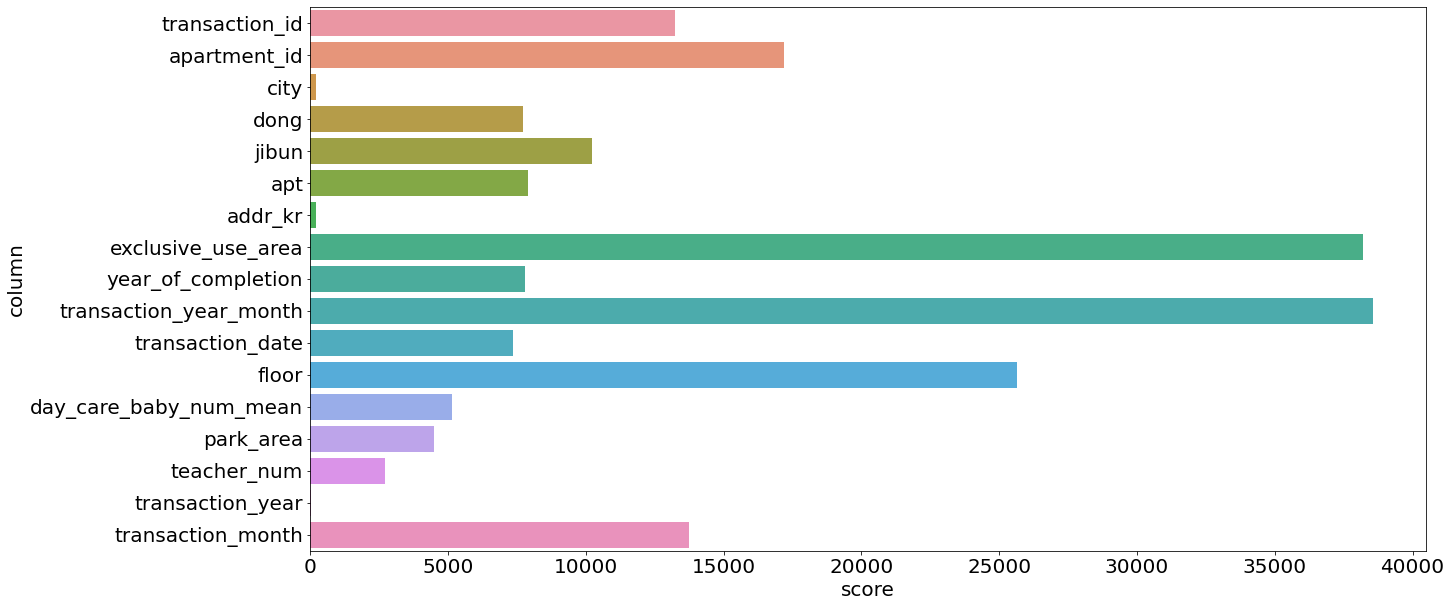

In [17]:
show_feature_importance(lgbm_model, X_valid)

## 2) astype('np.int64') 사용

In [58]:
# astype 및 데이터 분리
category_columns = ['apartment_id', 'city', 'dong', 'jibun', 'apt', 'addr_kr']
for column in category_columns:
    train[column] = train[column].astype(np.int64)                     # 범주형시 category. (lightgbm 시 사용)
    
drop_column = ['transaction_real_price']

X_data2 = train.drop(drop_column, axis=1)
y_data2 = train['transaction_real_price'].values
X_train2, X_valid2, y_train2, y_valid2 = train_test_split(X_data2, y_data2, test_size=0.2, random_state=42)

### 모델 선언 및 훈련 (LightGBM)

In [59]:
lgbm_model2 = LGBMRegressor(
    boosting_type='gbdt',
    num_leaves=31,
    max_depth=-1,
    learning_rate=0.1,
    n_estimators=20000,
    objective='regression',
    subsample=1.0,
    colsample_bytree=1.0,
    reg_alpha=0.0,
    reg_lambda=0.0,
    random_state=42,
    n_jobs=-1,
#         max_bin=2*9
)



In [60]:
lgbm_model2.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='rmse', verbose=200,
              early_stopping_rounds=200)

Training until validation scores don't improve for 200 rounds
[200]	training's rmse: 6809.08	training's l2: 4.63636e+07	valid_1's rmse: 6918.2	valid_1's l2: 4.78614e+07
[400]	training's rmse: 5733.55	training's l2: 3.28736e+07	valid_1's rmse: 5894.96	valid_1's l2: 3.47505e+07
[600]	training's rmse: 5190.85	training's l2: 2.69449e+07	valid_1's rmse: 5404.66	valid_1's l2: 2.92104e+07
[800]	training's rmse: 4825.96	training's l2: 2.32899e+07	valid_1's rmse: 5100.96	valid_1's l2: 2.60198e+07
[1000]	training's rmse: 4543.18	training's l2: 2.06405e+07	valid_1's rmse: 4866.47	valid_1's l2: 2.36825e+07
[1200]	training's rmse: 4328.44	training's l2: 1.87354e+07	valid_1's rmse: 4697.38	valid_1's l2: 2.20654e+07
[1400]	training's rmse: 4146.87	training's l2: 1.71965e+07	valid_1's rmse: 4556.83	valid_1's l2: 2.07647e+07
[1600]	training's rmse: 4005.74	training's l2: 1.6046e+07	valid_1's rmse: 4459.14	valid_1's l2: 1.98839e+07
[1800]	training's rmse: 3880.59	training's l2: 1.5059e+07	valid_1's rmse

[15200]	training's rmse: 2158.64	training's l2: 4.65973e+06	valid_1's rmse: 3670.45	valid_1's l2: 1.34722e+07
[15400]	training's rmse: 2150.72	training's l2: 4.62559e+06	valid_1's rmse: 3669.61	valid_1's l2: 1.3466e+07
[15600]	training's rmse: 2142.27	training's l2: 4.58934e+06	valid_1's rmse: 3669.1	valid_1's l2: 1.34623e+07
[15800]	training's rmse: 2133.9	training's l2: 4.55352e+06	valid_1's rmse: 3668.84	valid_1's l2: 1.34604e+07
Early stopping, best iteration is:
[15797]	training's rmse: 2134.1	training's l2: 4.5544e+06	valid_1's rmse: 3668.67	valid_1's l2: 1.34591e+07


LGBMRegressor(n_estimators=20000, objective='regression', random_state=42)

# - 성능
- [15797]
- training's rmse: 2134.1	
- training's l2: 4.5544e+06	
- valid_1's rmse: 3668.67	
- valid_1's l2: 1.34591e+07

- 비교
- 'categorical' : [6675]	training's rmse: 2450.84	training's l2: 6.00661e+06	valid_1's rmse: 3702.83	valid_1's l2: 1.3711e+07
- np.int64 : [15797]	training's rmse: 2134.1	training's l2: 4.5544e+06	valid_1's rmse: 3668.67	valid_1's l2: 1.34591e+07
Out[60]:


### feature_importance를 확인해보기.

In [61]:
#def show_feature_importance(model, data):
#    df=pd.DataFrame({'column':list(data.columns),
#              'score':list(model.feature_importances_),
#             })
#    plt.figure(figsize=(20,10))
#    sns.barplot(x="score", y="column", data=df)
#    plt.yticks(size=20)
#    plt.xticks(size=20)
#    plt.xlabel('score', size=20)
#    plt.ylabel('column', size=20)
#    plt.show()

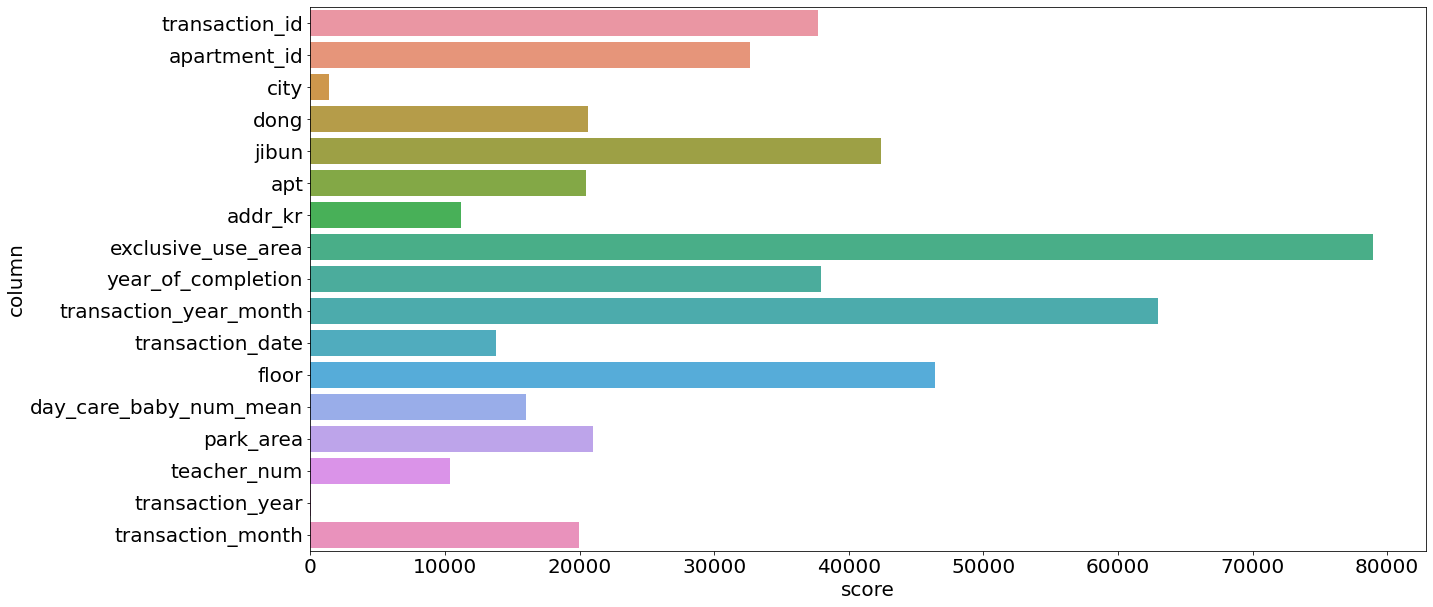

In [62]:
show_feature_importance(lgbm_model2, X_valid)

### LightGBM 외에 수업 때 사용했던 모델 이나 다른 모델을 1개 이상 선언하고 결과 확인하기.

# DecisionTreeRegressor

In [70]:
from sklearn.tree import DecisionTreeRegressor
model3 = DecisionTreeRegressor()

In [71]:
model3.fit(X_train.iloc[:, (X_train.isnull().sum()==0).values], y_train)

DecisionTreeRegressor()

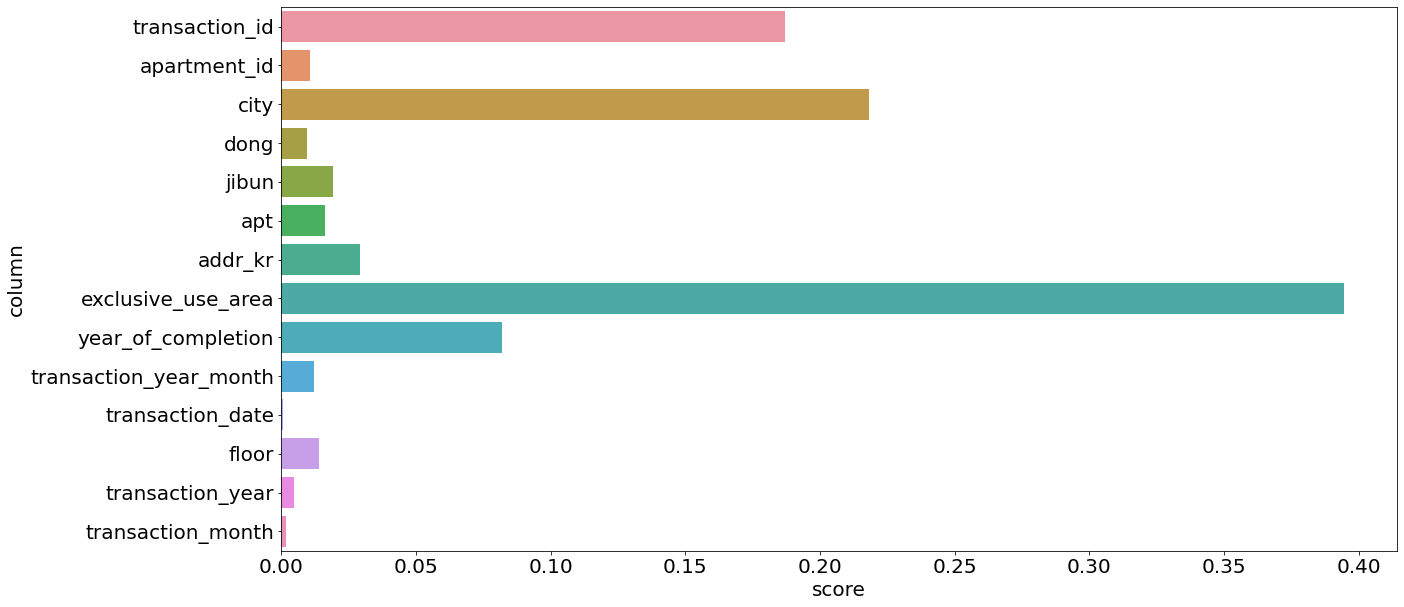

In [75]:
show_feature_importance(model3, X_train.iloc[:, (X_train.isnull().sum()==0).values])

# RandomForest

In [76]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
        n_estimators=100,
        criterion='mse',
        max_depth=None,
        min_samples_leaf=1,
        min_weight_fraction_leaf=0.0,
        n_jobs=-1,
        random_state=42,
        verbose=1,
)
rf.fit(X_train.iloc[:, (X_train.isnull().sum()==0).values], y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 12.8min finished


RandomForestRegressor(n_jobs=-1, random_state=42, verbose=1)

In [77]:
from sklearn.metrics import mean_squared_error

In [80]:
print(np.sqrt(mean_squared_error(y_valid, rf.predict(X_valid.iloc[:, (X_train.isnull().sum()==0).values]))))

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   15.3s


3944.5879191831477


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   31.7s finished


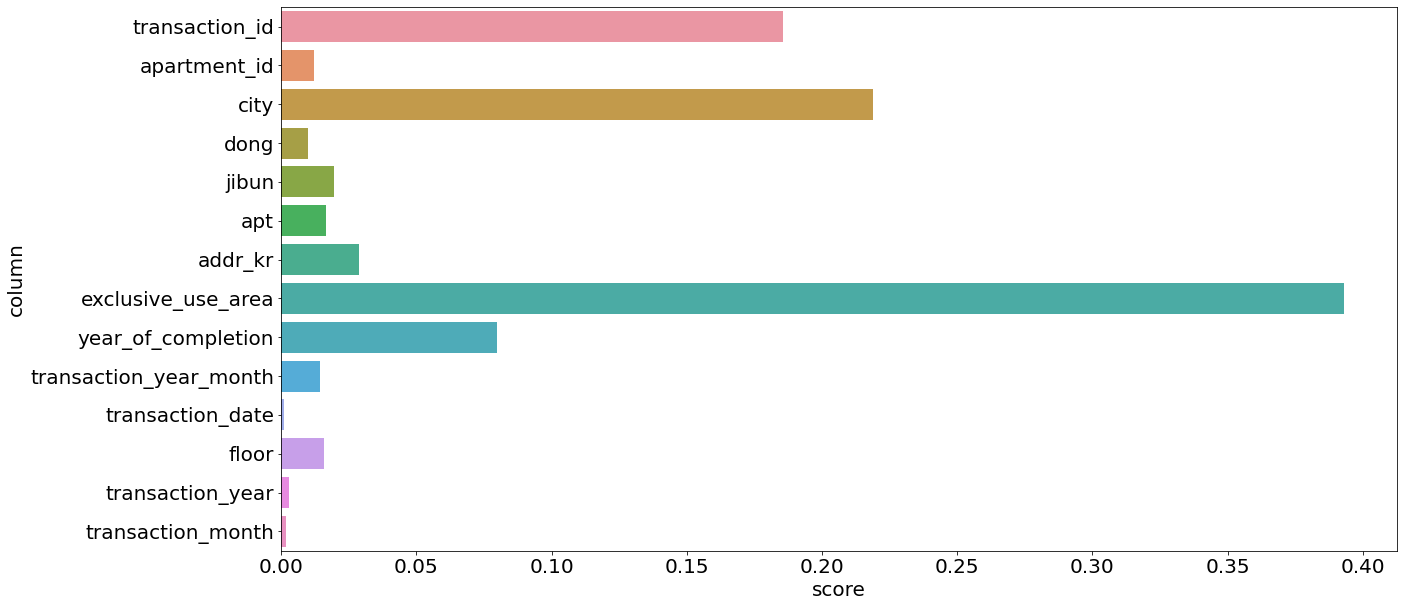

In [81]:
show_feature_importance(rf, X_train.iloc[:, (X_train.isnull().sum()==0).values])

## 변수 선택 및 파라미터 튜닝

- np.int64 기준 lightGBM 모델 기준 가장 feature importance가 적었던
'city', 'teacher_num' 변수 제거 시도

In [148]:
drop_column3 = ['city', 'teacher_num', 'transaction_real_price']

X_data3 = train.drop(drop_column3, axis=1)
y_data3 = train['transaction_real_price'].values
X_train3, X_valid3, y_train3, y_valid3 = train_test_split(X_data3, y_data3, test_size=0.2, random_state=42)

In [149]:
# np.int64 기준 lightGBM 튜닝
lgbm_model2_1 = LGBMRegressor(
    boosting_type='gbdt',
    num_leaves=31,
    max_depth=-1,
    learning_rate=0.1,
    n_estimators=20000,
    objective='regression',
    subsample=1.0,
    colsample_bytree=1.0,
    reg_alpha=0.0,
    reg_lambda=0.3, # 변화
    random_state=42,
    n_jobs=-1,
#         max_bin=2*9
)




In [150]:
lgbm_model2_1.fit(X_train3, y_train3, eval_set=[(X_train3, y_train3), (X_valid3, y_valid3)], eval_metric='rmse', verbose=200,
              early_stopping_rounds=200)

Training until validation scores don't improve for 200 rounds
[200]	training's rmse: 6972.93	training's l2: 4.86217e+07	valid_1's rmse: 7100.32	valid_1's l2: 5.04146e+07
[400]	training's rmse: 5844.43	training's l2: 3.41574e+07	valid_1's rmse: 6014.69	valid_1's l2: 3.61765e+07
[600]	training's rmse: 5265.26	training's l2: 2.7723e+07	valid_1's rmse: 5498.99	valid_1's l2: 3.02388e+07
[800]	training's rmse: 4872.64	training's l2: 2.37426e+07	valid_1's rmse: 5150.02	valid_1's l2: 2.65227e+07
[1000]	training's rmse: 4588.27	training's l2: 2.10522e+07	valid_1's rmse: 4911.99	valid_1's l2: 2.41277e+07
[1200]	training's rmse: 4370.33	training's l2: 1.90997e+07	valid_1's rmse: 4744.86	valid_1's l2: 2.25137e+07
[1400]	training's rmse: 4194.36	training's l2: 1.75927e+07	valid_1's rmse: 4607.09	valid_1's l2: 2.12252e+07
[1600]	training's rmse: 4048.12	training's l2: 1.63873e+07	valid_1's rmse: 4501.62	valid_1's l2: 2.02646e+07
[1800]	training's rmse: 3913.4	training's l2: 1.53147e+07	valid_1's rms

LGBMRegressor(n_estimators=20000, objective='regression', random_state=42,
              reg_lambda=0.3)

- 결과
[12301]	training's rmse: 2315.79	training's l2: 5.36289e+06	valid_1's rmse: 3703.74	valid_1's l2: 1.37177e+07

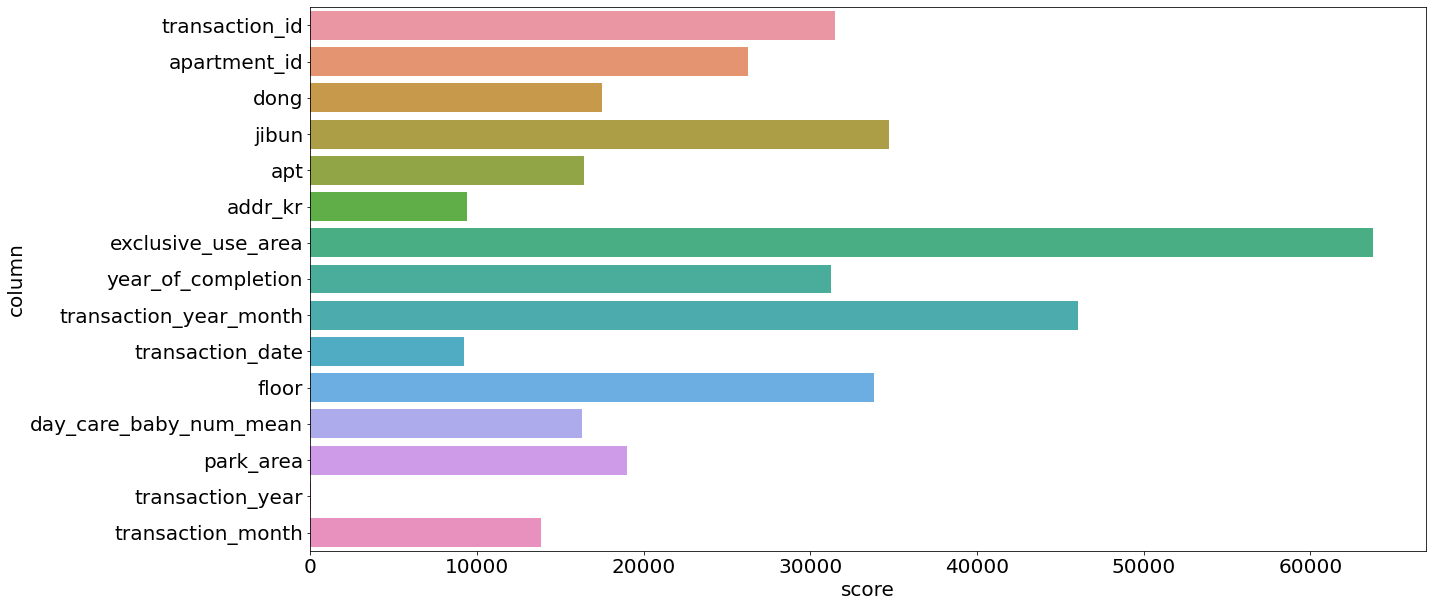

In [151]:
show_feature_importance(lgbm_model2_1, X_valid3)

- 변수 추가 제거 ('transaction_year', 'addr_kr')

In [152]:
drop_column4 = ['transaction_year', 'addr_kr']

X_data4 = X_data3.drop(drop_column4, axis=1)
y_data4 = train['transaction_real_price'].values
X_train4, X_valid4, y_train4, y_valid4 = train_test_split(X_data4, y_data4, test_size=0.2, random_state=42)

In [153]:
# np.int64 기준 lightGBM 튜닝
lgbm_model2_2 = LGBMRegressor(
    boosting_type='gbdt',
    num_leaves=31,
    max_depth=-1,
    learning_rate=0.1,
    n_estimators=20000,
    objective='regression',
    subsample=1.0,
    colsample_bytree=1.0,
    reg_alpha=0.0,
    reg_lambda=0.1, # 변화
    random_state=42,
    n_jobs=-1,
#         max_bin=2*9
)





In [154]:
lgbm_model2_2.fit(X_train4, y_train4, eval_set=[(X_train4, y_train4), (X_valid4, y_valid4)], eval_metric='rmse', verbose=200,
              early_stopping_rounds=200)

Training until validation scores don't improve for 200 rounds
[200]	training's rmse: 6900.4	training's l2: 4.76155e+07	valid_1's rmse: 7003.08	valid_1's l2: 4.90432e+07
[400]	training's rmse: 5804.12	training's l2: 3.36878e+07	valid_1's rmse: 5964.48	valid_1's l2: 3.55751e+07
[600]	training's rmse: 5270.43	training's l2: 2.77774e+07	valid_1's rmse: 5500.08	valid_1's l2: 3.02509e+07
[800]	training's rmse: 4884.98	training's l2: 2.38631e+07	valid_1's rmse: 5156.47	valid_1's l2: 2.65892e+07
[1000]	training's rmse: 4603.33	training's l2: 2.11907e+07	valid_1's rmse: 4922.11	valid_1's l2: 2.42272e+07
[1200]	training's rmse: 4385.99	training's l2: 1.92369e+07	valid_1's rmse: 4746.65	valid_1's l2: 2.25307e+07
[1400]	training's rmse: 4202.04	training's l2: 1.76572e+07	valid_1's rmse: 4606.51	valid_1's l2: 2.122e+07
[1600]	training's rmse: 4058.69	training's l2: 1.64729e+07	valid_1's rmse: 4504.97	valid_1's l2: 2.02948e+07
[1800]	training's rmse: 3928.6	training's l2: 1.54339e+07	valid_1's rmse:

LGBMRegressor(n_estimators=20000, objective='regression', random_state=42,
              reg_lambda=0.1)

- 결과
[13382]	training's rmse: 2263.31	training's l2: 5.12258e+06	valid_1's rmse: 3678.77	valid_1's l2: 1.35334e+07

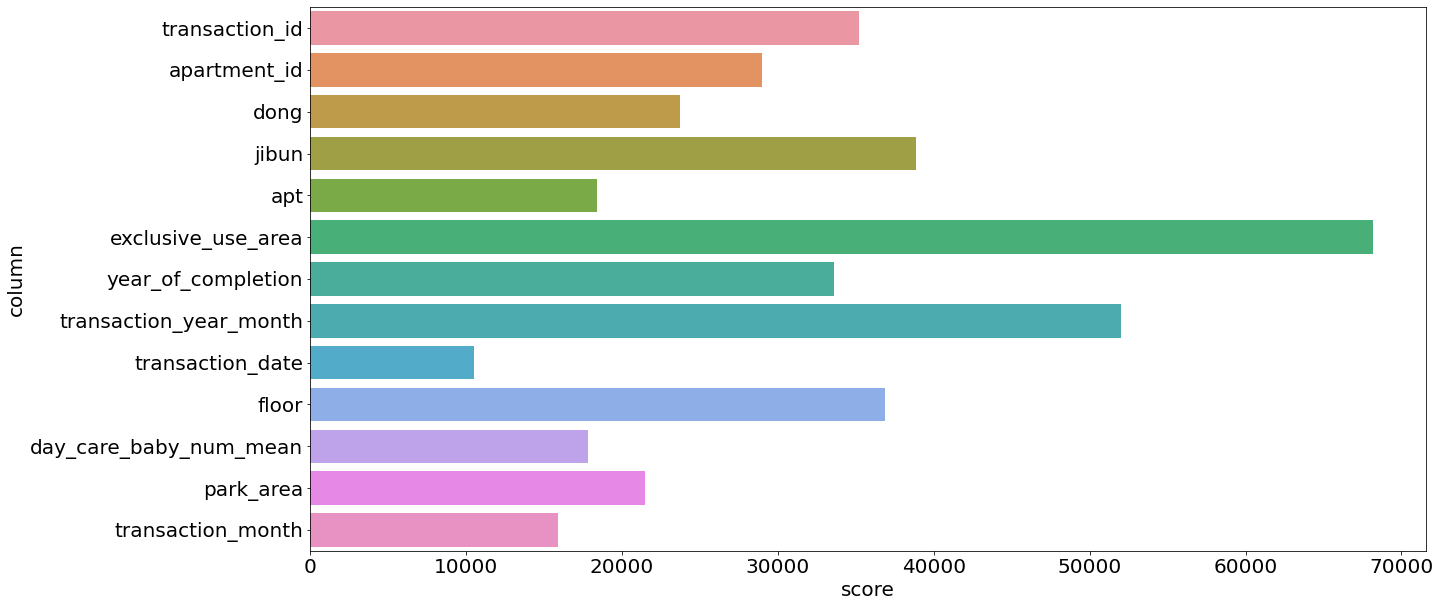

In [155]:
show_feature_importance(lgbm_model2_2, X_valid4)

In [156]:
submit = pd.read_csv('submission.csv')

In [125]:
submit

,transaction_id,transaction_real_price
0,1145756,0
1,1198704,0
2,1222384,0
3,1179897,0
4,1223091,0
...,...,...
5458,1174640,0
5459,1175575,0
5460,1157024,0
5461,1136863,0


In [157]:
X_data4.columns

Index(['transaction_id', 'apartment_id', 'dong', 'jibun', 'apt',
       'exclusive_use_area', 'year_of_completion', 'transaction_year_month',
       'transaction_date', 'floor', 'day_care_baby_num_mean', 'park_area',
       'transaction_month'],
      dtype='object')

In [158]:
len(X_data4.columns)

13

In [159]:
test.columns

Index(['transaction_id', 'apartment_id', 'city', 'dong', 'jibun', 'apt',
       'addr_kr', 'exclusive_use_area', 'year_of_completion',
       'transaction_year_month', 'transaction_date', 'floor',
       'day_care_baby_num_mean', 'park_area', 'teacher_num',
       'transaction_year', 'transaction_month'],
      dtype='object')

In [160]:
len(test.columns)

17

In [161]:
final_test = test.drop(['city', 'teacher_num', 'transaction_year', 'addr_kr'], axis=1)

In [162]:
len(final_test.columns)

13

In [163]:
pred = lgbm_model2_2.predict(final_test)

In [164]:
submit['transaction_real_price'] = pred
submit.to_csv('lgbm_model2_2_submission.csv', index=False)